In [1]:
from pyspark.sql import SparkSession
import os
    
# get ip address of master node (current machine)
ip = os.popen('hostname -i').read().strip('\n')
spark = SparkSession.builder \
    .master('local[28]') \
    .appName('crossValidated') \
    .config("spark.driver.maxResultSize", "3g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

Spark Session web UI: http://10.50.222.108:4040


In [2]:
lc = spark.read.json('/project/cmsc25025/light_curve/lightcurves-sample.json')
lc.show()
kp_num = lc.count()
print 'There are in total %d curves.' % kp_num

+--------------------+-----+--------------------+--------------------+
|                flux|label|                name|                time|
+--------------------+-----+--------------------+--------------------+
|[194602.078125, 1...| conf|kplr002581316-201...|[1274.14019845467...|
|[6818722.5, 68190...| conf|kplr003632418-201...|[1274.14035648731...|
|[48374.2421875, 4...| conf|kplr003733628-201...|[1274.14035006258...|
|[86651.015625, 86...| conf|kplr004150804-201...|[1274.14022049512...|
|[12159.1142578125...|   eb|kplr001026032-201...|[1274.14036272274...|
|[96343.7734375, 9...|   eb|kplr001026957-201...|[1274.14035174874...|
|[208676.5625, 208...|   eb|kplr001161345-201...|[1274.14035372128...|
|[3648.109375, 364...|   eb|kplr001432214-201...|[1274.14031962276...|
|[7149.537109375, ...|   fp|kplr000892772-201...|[1274.14036161633...|
|[1170351.625, 117...|   fp|kplr001025986-201...|[1274.14035989129...|
|[36673.83984375, ...|   fp|kplr001027438-201...|[1274.14034383971...|
|[2524

In [29]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def standardize_res(res):
    #standardize residual
    #sigma is estimated using median abosolute deviation(MAD)
    res_mean = np.mean(res)
    sigma = np.median(np.abs(res - np.median(res)))
    return (res - res_mean)/sigma
def remove_nan(x):
    #remove the nan values
    curve = np.array(zip(x['time'], x['flux']))
    return curve[~np.isnan(curve[:,1]),:]
def kernel_gaussian(curve_new, h):
    #Use a gaussian kernel to fit the curve
    nrow, ncol = curve_new.shape
    ys = np.zeros(nrow)
    risk = 0
    for i in range(nrow):
        u = (curve_new[i,0] - curve_new[:,0]) / h;
        w = np.exp(-u**2/2)
        w_sum = np.sum(w)
        ys[i] = w.dot(curve_new[:, 1]) / w_sum
        risk += ((ys[i] - curve_new[i, 1]) / (1 - 1/w_sum))**2
    risk /= nrow
    res = standardize_res(curve_new[:,1] - ys)
    thres = np.sqrt(2 * np.log(nrow))
    res[res >= - thres] = 0
    return np.column_stack((curve_new, ys)), risk, res, thres

In [27]:
lc_new = lc.rdd.map(remove_nan).cache()
kp = np.array(lc_new.collect())
print kp.shape

(12, 4325, 2)


With h value is 0.005000:
Risks for curves are:
[  4.38569616e+02   1.31363115e+05   1.06565585e+02   1.54051959e+02
   1.39854871e+02   2.07518202e+02   9.59923789e+02   1.91541002e+01
   3.97131136e+01   3.63215904e+03   9.99548431e+01   1.11003266e+02]
With h value is 0.010000:
Risks for curves are:
[  4.38121537e+02   1.31248383e+05   1.06442676e+02   1.53842031e+02
   1.40335265e+02   2.07272151e+02   9.59195496e+02   1.91452138e+01
   3.96605725e+01   3.62605335e+03   9.98273298e+01   1.10857174e+02]
With h value is 0.050000:
Risks for curves are:
[  5.57421641e+02   1.08464186e+05   8.75916946e+01   1.15654692e+02
   1.46631476e+03   1.83838021e+02   9.55947069e+02   3.20812601e+01
   2.96560417e+01   3.23487909e+03   7.85759096e+01   8.28332563e+01]
With h value is 0.100000:
Risks for curves are:
[  1.18470299e+03   1.07738867e+05   9.57859449e+01   1.20993616e+02
   4.01641483e+03   2.44196402e+02   1.27823242e+03   7.25411848e+01
   2.93597640e+01   6.11532025e+03   8.1721139

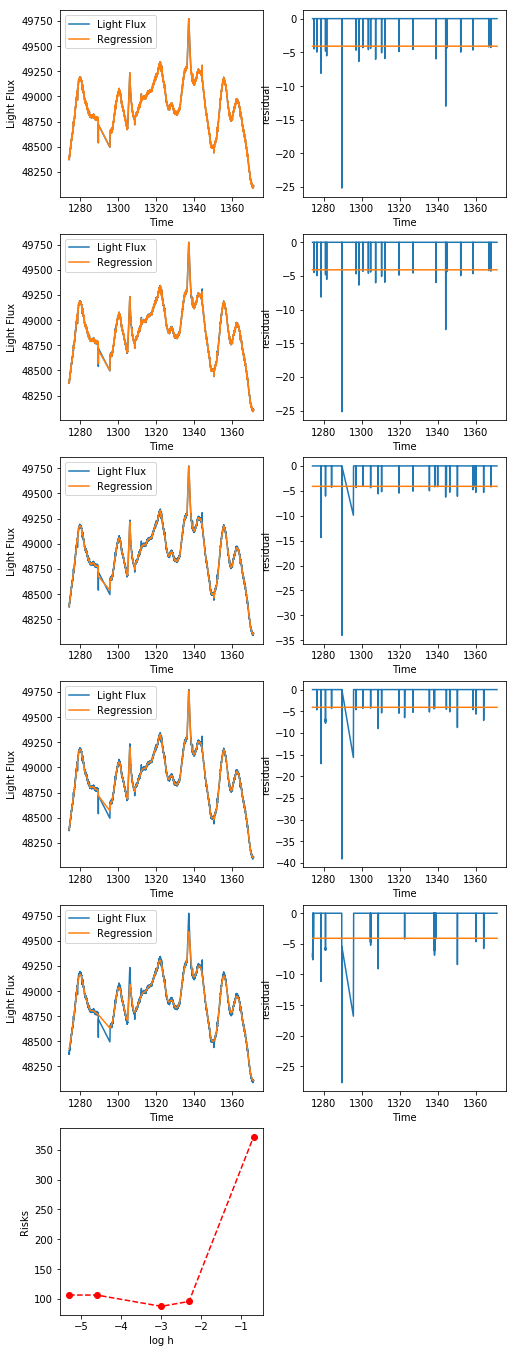

In [38]:
h_range = [0.005, 0.01, 0.05, 0.1, 0.5]
h_num = len(h_range)
risks = np.zeros((h_num, kp_num))
res = np.zeros((h_num, kp_num, kp.shape[1]))
thres = np.zeros(kp_num)
kp_fit = np.zeros((h_num, kp_num, kp.shape[1]))

ncols = 2
nrows = h_num + 1
plt.figure(figsize = (ncols*4, nrows*4))
for hi in range(len(h_range)):
    h = h_range[hi]
    print 'With h value is %f:' % h
    kcurve = lc_new.map(lambda x: kernel_gaussian(x, h)).collect()
    for i in range(kp_num):
        risks[hi][i] = kcurve[i][1]
        res[hi, i, :] = kcurve[i][2]
        kp_fit[hi, i, :] = kcurve[i][0][:,2]
        if hi == 0:
            thres[i] = kcurve[i][3]
    print 'Risks for curves are:'
    print risks[hi]
    plt.subplot(nrows,ncols,2 * hi+1)
    plt.plot(kcurve[2][0][:,0], kcurve[2][0][:,1], label = 'Light Flux')
    plt.legend()
    plt.plot(kcurve[2][0][:,0], kcurve[2][0][:,2], label = 'Regression')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.subplot(nrows,ncols,2 * hi+2)
    plt.plot(kcurve[2][0][:,0], kcurve[2][2])
    plt.plot(kcurve[2][0][:,0], -thres[2] * np.ones(kp.shape[1]))
    plt.xlabel('Time')
    plt.ylabel('residual')
index = np.argmin(risks, axis=0)
plt.subplot(nrows, ncols, nrows * ncols - 1)
plt.plot(np.log(np.array(h_range)), risks[:,2], 'ro--')
plt.xlabel('log h')
plt.ylabel('Risks')
plt.show()


Name			Opitimal h:
kplr002581316-2012277125453_llc:	0.010000
kplr003632418-2012277125453_llc:	0.100000
kplr003733628-2012277125453_llc:	0.050000
kplr004150804-2012277125453_llc:	0.050000
kplr001026032-2012277125453_llc:	0.005000
kplr001026957-2012277125453_llc:	0.050000
kplr001161345-2012277125453_llc:	0.050000
kplr001432214-2012277125453_llc:	0.010000
kplr000892772-2012277125453_llc:	0.100000
kplr001025986-2012277125453_llc:	0.050000
kplr001027438-2012277125453_llc:	0.050000
kplr001161949-2012277125453_llc:	0.100000


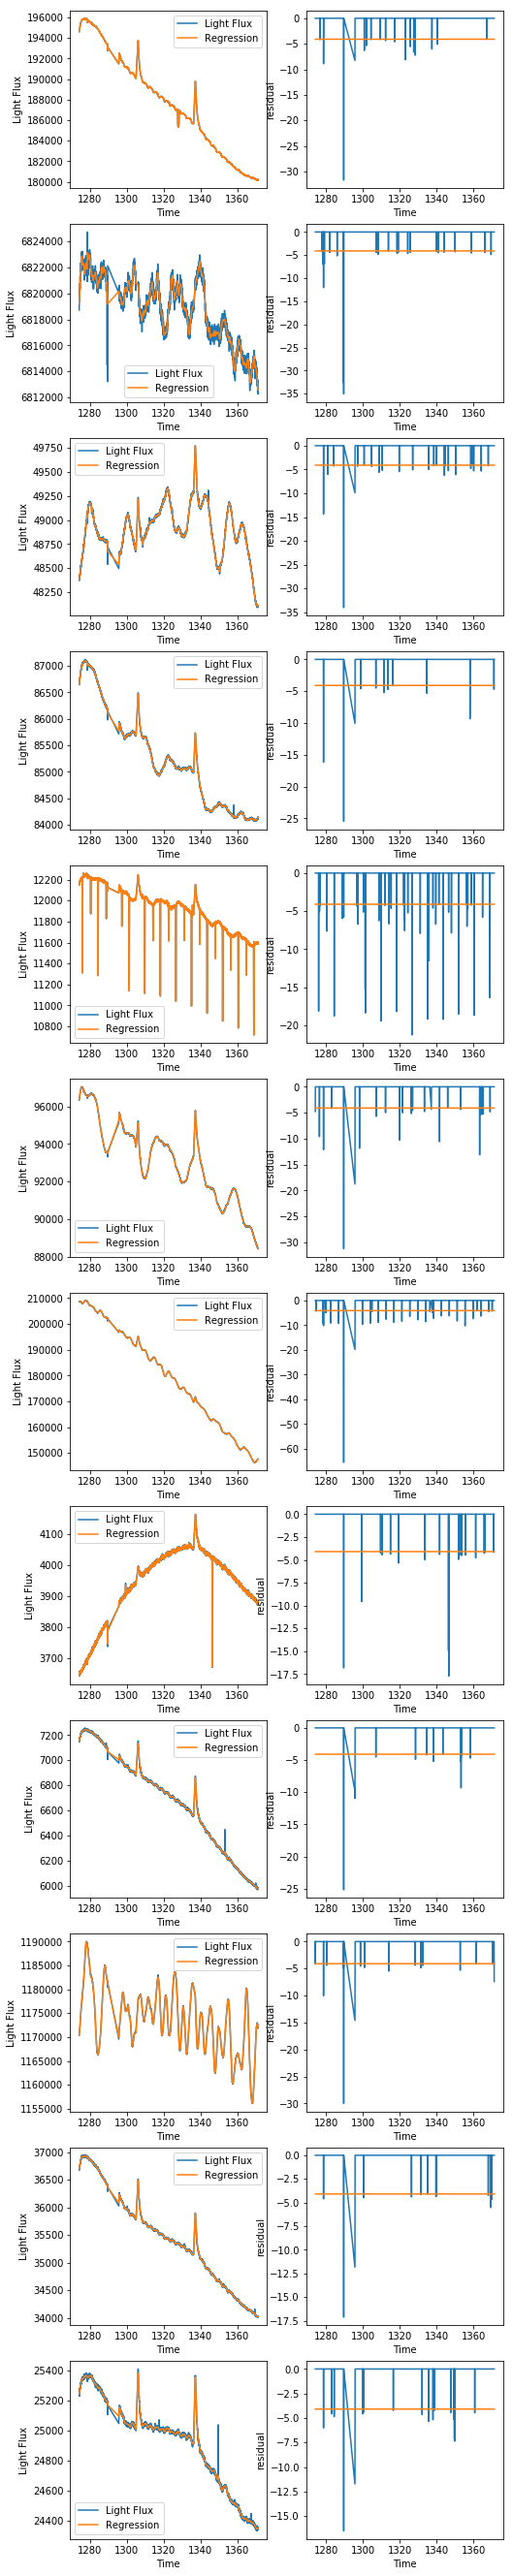

In [35]:
kp_names = lc.rdd.map(lambda x: x['name']).collect()
nrows = kp_num
ncols = 2
plt.figure(figsize = (ncols*4, nrows*4))
print 'Name\t\t\tOpitimal h:'
for i in range(kp_num):
    h = h_range[index[i]]
    print '%s:\t%f' % (kp_names[i], h)
    plt.subplot(nrows,ncols,2 * i+1)
    plt.plot(kp[i][:,0], kp[i][:,1], label = 'Light Flux')
    plt.legend()
    plt.plot(kp[i][:,0], kp_fit[index[i], i, :], label = 'Regression')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.subplot(nrows,ncols,2 * i+2)
    plt.plot(kp[i][:,0], res[index[i], i, :])
    plt.plot(kp[i][:,0], -thres[i] * np.ones(kp.shape[1]))
    plt.xlabel('Time')
    plt.ylabel('residual')
plt.show()



Comments: These fitted plots suggest that there are planets in star 1-4 since there are periodic spikes; there are binary system in star 5-8 since there are some periodic spikes but the plots have some other patterns not observed in planet systems; there are no planets in star 9-12 since the plots are more noisy.